In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import time
from time import perf_counter
import glob
import json
import matplotlib.pyplot as plt
%autosave 3600

Autosaving every 3600 seconds


In [3]:
path = glob.glob('C:/Users/Gianluca/Desktop/provascript/*.json')
path

['C:/Users/Gianluca/Desktop/provascript\\score_results_prova.json']

# Todo
 - leggi i file in base al tipo di tweet
 - dividi in tipologia di bot (tira fuori le stats)
 - prendi gli id e usali nel dataframe totale

In [3]:
threshold = 0.5
id_issue = dict()
list_raws = []
total_users = 0
total_bots = 0
total_person = 0
bots = []

In [4]:
def convert(list):
    return tuple(list)

In [5]:
import json
  
f = open(path[0],)
data = json.load(f)

for i in data:
    obj = data[i]
    id_user = obj["id"]
    screen_name = obj["screen_name"]
    score = obj["scores"]
    raw = score["raw_scores"]
    raw_universal = raw["universal"]
    list_tuple = []
    list_raws = list(raw_universal.keys())
    list_raws.pop(4) # remove overall in process
    for j in list_raws:
        if raw_universal[j] >= threshold:
            list_tuple.append(j)
            bots.append((id_user, screen_name))
    id_issue[str(i)] = convert(list_tuple)
f.close()
bots = list(set(bots))

In [6]:
for i in id_issue.keys():
    total_users = total_users + 1 
    if len(id_issue[i]) > 0:
        total_bots = total_bots + 1
    else:
        total_person = total_person + 1

In [7]:
print(f'Number of total users: {total_users}')
print(f'Number of bots: {total_bots}')
print(f'Number of person: {total_person}')

perc_bot = np.around(total_bots*100/total_users,2)
perc_person = np.around(total_person*100/total_users,2)
print(f'Perc of bots: {perc_bot}% of total users')
print(f'Perc of person: {perc_person}% of total users')

Number of total users: 10
Number of bots: 6
Number of person: 4
Perc of bots: 60.0% of total users
Perc of person: 40.0% of total users


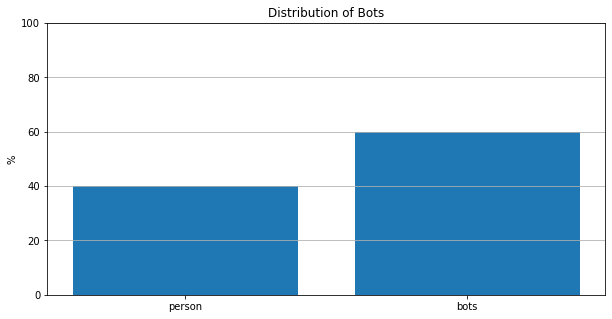

In [8]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
ax.bar(np.arange(2), np.asarray([total_person, total_bots])*(100/total_users))
ax.set_xticks(np.arange(2))
ax.set_xticklabels(['person', 'bots'])
ax.set_ylabel('%')
ax.yaxis.grid(True)
ax.set_ylim([0,100])
ax.set_title('Distribution of Bots')
#plt.savefig('files/plots/tweets_division')
plt.show()

#### Categorie:
- cap: probabilità condizionale che un utente con un punteggio maggiore o uguale a questo sia automatizzato (sia nella lingua dell'utente che in inglese)
- display scores: come raw score ma con un range che va da [0,5]
- raw scores: bot score con range che va da [0,1], sia in inglese che nella lingua dell'utente, contiene sottocategorie
- user: Utente Twitter con informazioni sull'id, nome e lingua dedotta dalla maggioranza dei tweet

#### Sottocategorie:
- fake_follower: bot acquistati per aumentare il numero di follower
- self_declared: bot da botwiki.org
- astroturf: bot politici etichettati manualmente e account coinvolti in follow trains che cancellano sistematicamente i propri contenuti
- spammer: account etichettati come spambot
- financial: bot che usando i cashtag
- other: vari altri bot ottenuti da annotazioni manuali, feedback degli utenti, ecc.



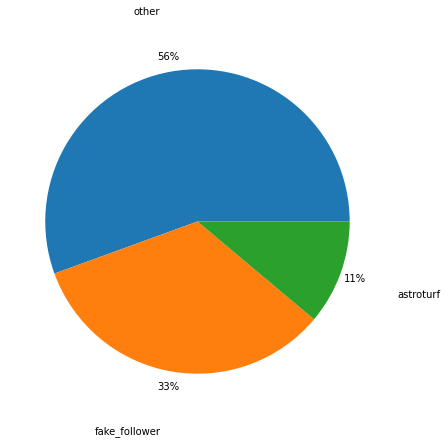

In [9]:
a = []
for k,v in id_issue.items():
    for i in v:
        a.append(i)
a = pd.Series(a).value_counts().sort_values(ascending=False)
plot = a.plot.pie(autopct='%1.0f%%', pctdistance=1.1, labeldistance=1.4, label="", figsize=(7, 7))

# Split csv into small subfiles

In [10]:
def split_csv(name, dim, outputname):
    path_split = glob.glob("C:/Users/Gianluca/Desktop/Supsi/Git/BachelorProject/to_be_scored/*.csv")
    for i in range(len(path_split)):
        if name in path_split[i]:
            df = pd.read_csv(path_split[i])
    file_len = len(df)
    filename = 'C:/Users/Gianluca/Desktop/provascript/' + str(outputname)
    n = 1
    for i in range(file_len):
        if i % dim == 0:
            sf = (df[i:i+dim])
            sf.to_csv(f'{filename}_{n}.csv', index=False)
            n += 1